# **Importing Libraries:**


In [1]:
# Libraries for Data Manipulation
import numpy as np
import pandas as pd


# Libraries for Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt


# Libraries to Handle Warnings
import warnings
warnings.filterwarnings('ignore')


# Libraries to Handle Machine Learning Models
import joblib
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier


# Model Evaluation Metrics
from sklearn.metrics import (
    f1_score,
    recall_score,
    roc_auc_score,
    accuracy_score,
    precision_score,
    confusion_matrix,
    classification_report,
)

# **Loading data**


In [2]:
x_train_scaled = pd.read_csv('./DATASET/EDA-DATASET/x_train_scaled.csv')
x_test_scaled = pd.read_csv('./DATASET/EDA-DATASET/x_test_scaled.csv')
y_train = pd.read_csv('./DATASET/EDA-DATASET/y_train.csv')
y_test = pd.read_csv('./DATASET/EDA-DATASET/y_test.csv')

### **Function to evaluate model**


In [3]:
def evaluate_model(y_test, y_pred, y_prob):
    accuracy = accuracy_score(
        y_test,
        y_pred
    )

    precision = precision_score(
        y_test,
        y_pred,
        average='weighted'
    )

    recall = recall_score(
        y_test,
        y_pred,
        average='weighted'
    )

    f1 = f1_score(
        y_test,
        y_pred,
        average='weighted'
    )

    conf_matrix = confusion_matrix(
        y_test,
        y_pred
    )

    class_report = classification_report(
        y_test,
        y_pred
    )

    roc_auc = roc_auc_score(
        y_test,
        y_prob,
        multi_class='ovr',
        average='weighted'
    )

    return accuracy, precision, recall, f1, conf_matrix, class_report, roc_auc

# **Hyper-Parameter Tuning Setups**


### **Parameter grid for Random Forest (RF)**


In [4]:
param_grid_rf = {
    # 'n_estimators': Number of trees in the Random Forest.
    # Setting it to 100, a common choice for balancing performance and computational cost.
    'n_estimators': [100],

    # 'max_depth': Maximum depth of each tree.
    # 'None' allows trees to grow until all leaves are pure or have fewer than min_samples_split samples.
    # Setting an additional option '10' to limit depth and reduce overfitting.
    'max_depth': [None, 10],

    # 'min_samples_split': Minimum number of samples required to split an internal node.
    # Setting this to 2, the default, which allows nodes to be split as long as they have at least 2 samples.
    'min_samples_split': [2],

    # 'min_samples_leaf': Minimum number of samples required to be at a leaf node.
    # Setting to 1, allowing leaves to contain as few as 1 sample, providing the most granular splits.
    'min_samples_leaf': [1],

    # 'bootstrap': Whether bootstrap samples are used to build trees.
    # 'True' enables bootstrapping, which introduces randomness, a typical practice for Random Forests.
    'bootstrap': [True]
}

### **Perform GridSearchCV for Random Forest**


In [5]:
grid_search_rf = GridSearchCV(
    # RandomForestClassifier as the model with a fixed random state for reproducibility
    estimator=RandomForestClassifier(random_state=42),
    # Parameter grid defined earlier for RF
    param_grid=param_grid_rf,
    # 2-fold cross-validation to split the training data for evaluation
    cv=5,
    # accuracy as the evaluation metric
    scoring='f1_weighted',
    # Set verbosity level to show progress of the grid search
    verbose=1,
    # Using all available CPU cores to parallelize the computation
    n_jobs=-1
)


# Fitting the grid search to the training data to find the best hyperparameters for RF
grid_search_rf.fit(x_train_scaled, y_train)


# Saving the best RF model with the optimal hyperparameters found
best_rf_model = grid_search_rf.best_estimator_

Fitting 5 folds for each of 2 candidates, totalling 10 fits


## **Running Predictions and Evaluation**


- **Predicting the class labels and probabilities using Random Forest model**


In [6]:
# Class labels
y_pred_rf = best_rf_model.predict(x_test_scaled)

# Class probabilities
y_prob_rf = best_rf_model.predict_proba(x_test_scaled)


# Evaluating the Random Forest model using various metrics defined above
accuracy_rf, precision_rf, recall_rf, f1_rf, conf_matrix_rf, class_report_rf, roc_auc_rf = evaluate_model(
    y_test, y_pred_rf, y_prob_rf)

## **Confusion Matrix**


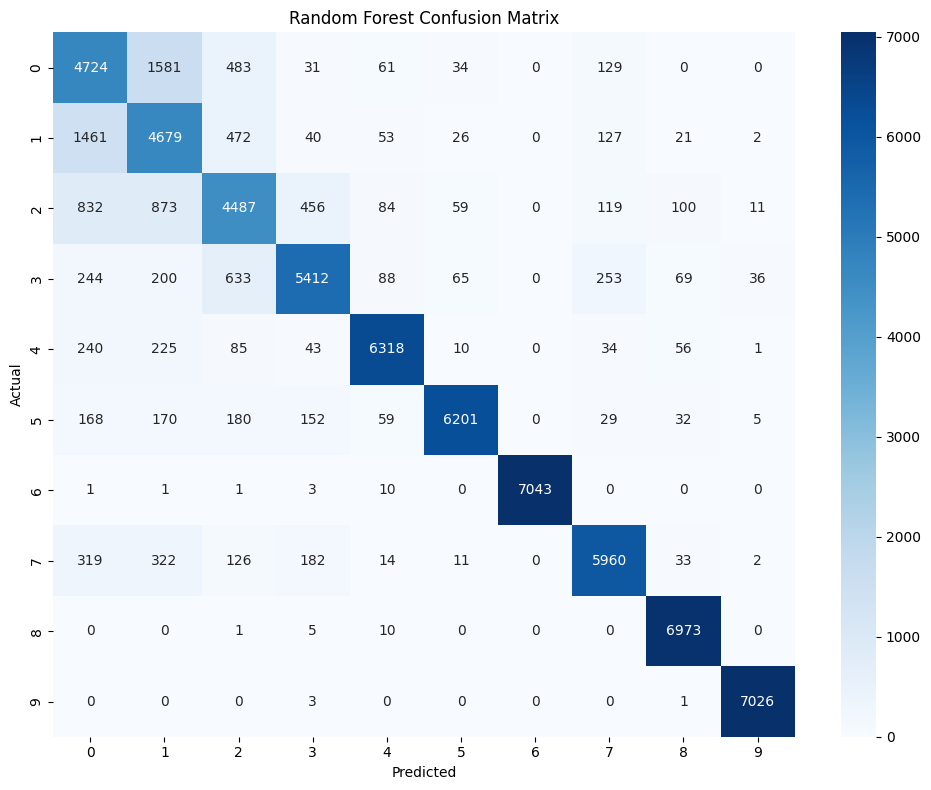

In [7]:
fig, ax = plt.subplots(figsize=(10, 8))


sns.heatmap(
    conf_matrix_rf,
    annot=True,
    fmt='d',
    cmap='Blues',
    ax=ax
)

ax.set_title('Random Forest Confusion Matrix')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()

## **ROC-AUC Curves**


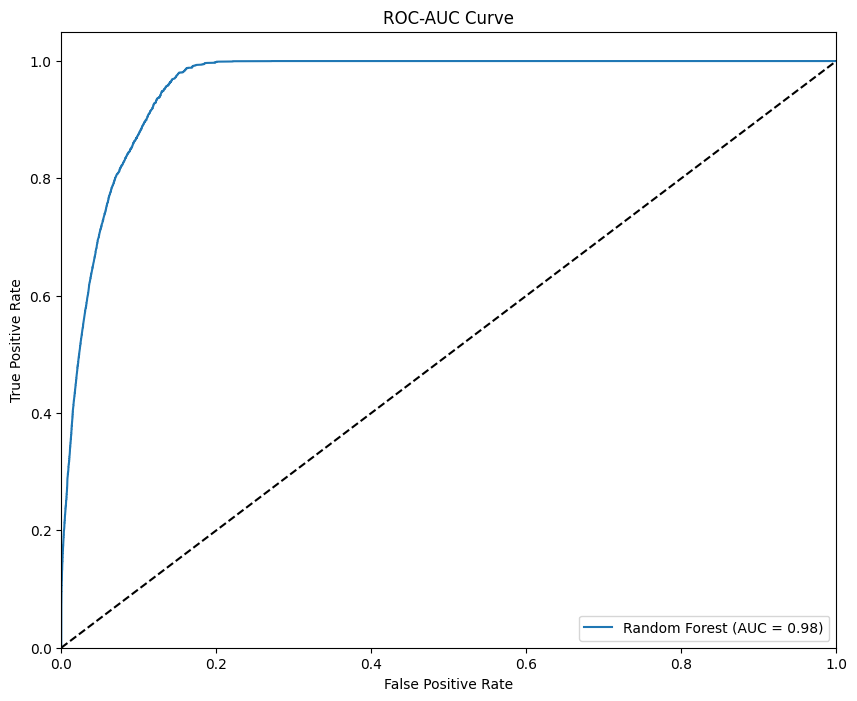

In [8]:
plt.figure(figsize=(10, 8))


fpr_rf, tpr_rf, _ = roc_curve(
    y_test,
    y_prob_rf[:, 1],
    pos_label=1
)


# ROC curve for Random Forest model
plt.plot(
    fpr_rf,
    tpr_rf,
    label='Random Forest (AUC = {:.2f})'.format(roc_auc_rf)
)


# Plot a diagonal line representing a random classifier (50% chance)
# 'k--' == means black dashed line
plt.plot([0, 1], [0, 1], 'k--')


plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve')


plt.legend(loc='lower right')


plt.show()

## **Model Summary Table**


In [9]:
summary = pd.DataFrame({
    'Model': ['Random Forest'],
    'Accuracy': [accuracy_rf],
    'Precision': [precision_rf],
    'Recall': [recall_rf],
    'F1 Score': [f1_rf],
    'ROC-AUC': [roc_auc_rf]
})


print("Model Comparison Summary:")
print(summary)

Model Comparison Summary:
           Model  Accuracy  Precision    Recall  F1 Score   ROC-AUC
0  Random Forest  0.840329   0.848233  0.840329  0.843009  0.976218


In [10]:
joblib.dump(best_rf_model, '05_RandomForestModel.pkl')

['05_RandomForestModel.pkl']

## **Random Forest Model Summary**

### **Performance Comparison Across Different Configurations**

| **CV** | **Scoring**   | **Accuracy** | **Precision** | **Recall** | **F1 Score** | **ROC-AUC** | **Comments**                        |
|--------|---------------|--------------|---------------|------------|--------------|-------------|-------------------------------------|
| 2      | `accuracy`    | 0.831357     | 0.838375      | 0.831357   | 0.833956     | 0.976437    | Slightly lower metrics than 5-fold  |
| 5      | `accuracy`    | 0.840329     | 0.848233      | 0.840329   | 0.843009     | 0.976218    | Robust and optimal configuration    |
| 2      | `f1`          | 0.840329     | 0.848233      | 0.840329   | 0.843009     | 0.976218    | Similar performance to accuracy CV5 |
| 5      | `f1`          | 0.840329     | 0.848233      | 0.840329   | 0.843009     | 0.976218    | Consistently high performance       |
| 5      | `f1_weighted` | 0.840329     | 0.848233      | 0.840329   | 0.843009     | 0.976218    | Ideal for imbalanced datasets       |

---

### **Observations**

1. **Uniform Metrics Across Configurations**:
   - All configurations, except 2-fold CV with `accuracy`, show nearly identical metrics, highlighting the model's robustness.
   - Consistent accuracy, precision, recall, F1 score, and ROC-AUC (~0.976218) indicate stable performance.

2. **2-fold vs. 5-fold Cross-Validation**:
   - 5-fold CV yields slightly better performance metrics and provides a more stable evaluation.
   - 2-fold CV is computationally efficient but may lead to higher variance due to fewer validation splits.

3. **Accuracy vs. F1 Scoring**:
   - Accuracy is less informative for imbalanced datasets.
   - `f1_weighted` is recommended as it considers both precision and recall, particularly useful for datasets with class imbalance.

4. **ROC-AUC**:
   - The consistently high ROC-AUC (~0.976) across configurations shows excellent separability between classes, confirming the model's robustness.
---

## **Key Inferences**

1. **Comparison of Models (Decision Tree vs. Random Forest)**:
   - **Random Forest (AUC ≈ 0.976)**:  
      - The Random Forest model consistently achieves a higher AUC score (~0.976) across configurations, reflecting superior capability in distinguishing between positive and negative classes. 
      - Its metrics (Accuracy, Precision, Recall, and F1 Score) are stable across various configurations, reinforcing its robustness and reliability.  
   - **Decision Tree (AUC ≈ 0.944)**:  
      - While the Decision Tree model also performs well, its AUC is slightly lower (~0.944 in the best configuration), suggesting it is less effective than Random Forest at class discrimination. 
      - The Decision Tree also shows variability across configurations, particularly in `f1` scoring for 2-fold CV, highlighting less consistent performance.

2. **ROC Curve Shapes**:
   - **Random Forest**:  
      - The ROC curve rises sharply toward the top-left corner, indicating a high true positive rate and low false positive rate early in its predictions. 
      - This steepness confirms its ability to make confident and accurate predictions.  
   - **Decision Tree**:  
      - The ROC curve, while still effective, is less steep than Random Forest's. 
      - This suggests that the Decision Tree model requires further optimization or that it is less confident in distinguishing classes compared to Random Forest.

3. **Diagonal Line (Random Classifier)**:
   - Both models outperform the diagonal baseline (AUC = 0.5), representing a random classifier. Their AUC scores demonstrate they are effective at separating classes.

4. **Evaluation of Scoring Metrics**:
   - Random Forest performs equally well with different scoring metrics (`accuracy`, `f1`, `f1_weighted`), making it robust for balanced and imbalanced datasets.
   - Decision Tree shows variability in metrics, with `f1_weighted` scoring in 5-fold CV being the most reliable configuration.

5. **Conclusion**:
   - **Random Forest** is the better-performing model due to its higher AUC, consistent performance across configurations, and robustness in handling class imbalances. It is well-suited for deployment in scenarios where precision and recall are equally important.  
   - **Decision Tree**, while slightly inferior, is computationally less intensive and may still be useful for simpler tasks or when interpretability is a priority. It achieves competitive performance in its best configuration (5-fold CV with `f1_weighted` scoring).

---
---